In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shap

In [ ]:
# read train data
train_df= pd.read_csv('train.csv')
#read test data
test_df = pd.read_csv('test.csv')
train_df.head()

In [42]:
# hin = pd.read_csv("Cache/Embeddings/lda_bn.csv")
# whole_data = pd.read_csv("Data/cleaned bangla.csv")
# le = LabelEncoder()
# y = pd.DataFrame(le.fit_transform(whole_data["Sub-task A"]))
# X_train, X_test, Y_train, Y_test = train_test_split(hin, y, test_size=0.3, random_state=2)
# train_df=pd.DataFrame(X_train)
# test_df=pd.DataFrame(X_test)

In [2]:
x = pd.read_csv("Cache/Embeddings/tfidf.csv")
# y = pd.read_csv("Data/cleaned english.csv")["Sub-task A"]
y = pd.read_csv("Data/y_eng_oversampled.csv", header=None)
le = LabelEncoder()
y = le.fit_transform(y.iloc[:, 0])
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=4)
train_df=pd.DataFrame(X_train)
test_df=pd.DataFrame(X_test)

In [3]:
train_df.isna().any().any(), test_df.isna().any().any()

(False, False)

In [4]:
train_df.head()

,agree,arundhati,arundhati roy,bitch,bollywood,brother,but,called,country,don,...,totally,toxic,understand,video,watch,watching,what,why,woman,women
1675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.524753,0.0,0.0,0.0,0.0,0.0,0.0
2678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_df.drop(['Y'], axis=1, inplace=True)
test_df.drop(['Y'], axis=1, inplace=True)

In [5]:
train_df['dataset_label'] = 1
test_df['dataset_label'] = 0
combined_data = pd.concat([train_df, test_df], axis = 0)

In [6]:
def adversarial_validation(dataset, train_data, test_data):
    dataset = dataset.sample(frac=1)
    av_train = dataset[:len(train_data)]
    av_test = dataset[len(train_data):]
    return av_train, av_test
av_train, av_test = adversarial_validation(combined_data, train_df, test_df)
train_data = Pool(
    data=av_train.drop('dataset_label',1),
    label=av_train['dataset_label']
)
remaining_data = Pool(
    data=av_test.drop('dataset_label',1),
    label=av_test['dataset_label']
)
col_to_list = combined_data.columns.tolist()
col_to_list.remove('dataset_label')
metrics = {
    'iterations': 500,
    'eval_metric': 'AUC'
}
model = CatBoostClassifier(**metrics)
_ = model.fit(train_data, eval_set=remaining_data, plot=False, verbose=False)

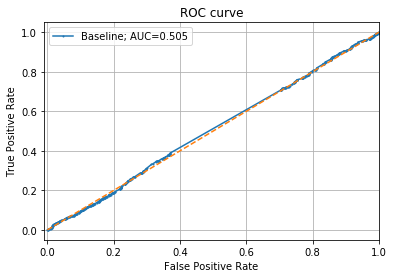

In [7]:
def rocgraph(y_trues, y_preds, labels, x_max=1.0):
    fig, ax = plt.subplots()
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        ax.plot(fpr, tpr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)
    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')
rocgraph(
    [remaining_data.get_label().astype('int')],
    [model.predict_proba(remaining_data)[:,1]],
    ['Baseline']
)

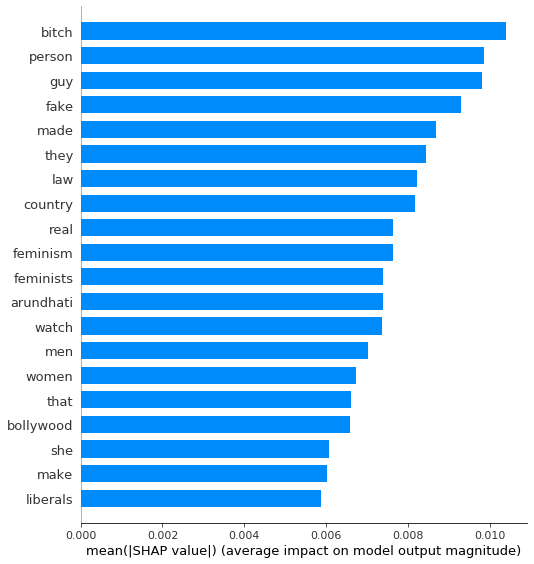

In [8]:
def plot_features(model, remaining_data, features):
    featurevalues = model.get_feature_importance(remaining_data, type='ShapValues')
    expected_value = featurevalues[0,-1]
    featurevalues = featurevalues[:,:-1]
    shap.summary_plot(featurevalues, remaining_data, feature_names=features, plot_type='bar')
plot_features(model, remaining_data, combined_data.columns)

In [9]:
train_df.shape, test_df.shape

((8843, 65), (3790, 65))

In [10]:
train_df['Y'] = Y_train
train_df.drop(columns=['dataset_label'], inplace=True)
train_df.head()

,agree,arundhati,arundhati roy,bitch,bollywood,brother,but,called,country,don,...,toxic,understand,video,watch,watching,what,why,woman,women,Y
1675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1
9372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.524753,0.0,0.0,0.0,0.0,0.0,0.0,2
2678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1
9299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2
2422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1


In [11]:
train_df.to_csv("Data/eng_train_tfidf.csv", index=False)

In [12]:
test_df['Y'] = Y_test
test_df.drop(columns=['dataset_label'], inplace=True)
test_df.head()

,agree,arundhati,arundhati roy,bitch,bollywood,brother,but,called,country,don,...,toxic,understand,video,watch,watching,what,why,woman,women,Y
511,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6014,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3045,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
929,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7301,0.580677,0.0,0.0,0.0,0.0,0.633447,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [13]:
test_df.to_csv("Data/eng_test_tfidf.csv", index=False)